# About this project:

This project aims to train a neural network model to identify the presence of COVID-19 from images of Chest X-Rays. A model that works well would be useful for accelerating the identification of infected individuals, especially in countries where hospitals are overwhelmed and can benefit from streamlining the testing process.


## Dataset information:


The dataset was downloaded from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset


## Content

The dataset contains ~5800 jpeg images of Chest X-Rays of Healthy patients, as well as patients affected with Pneumonia. The pneumonia X-Rays contain cases of bacterial infections as well as viral infections, such as SARS (Severe Acute Respiratory Syndrome ) ,Streptococcus & ARDS (Acute Respiratory Distress Syndrome).


## Acknowledgements

This analysis is made possible by the dataset compiled by Joseph Paul Cohen. Postdoctoral Fellow, Mila, University of Montreal.

Original Source :- https://github.com/ieee8023/covid-chestxray-dataset

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import PIL
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#For organizing image folders
import shutil
import os

from sklearn.model_selection import train_test_split

import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization
import kerastuner as kt

# Ensure we use GPU for faster neural network training

Note: For this notebook we create a virtual environment with the tensorflow-gpu package instead of the usual tensorflow. This ensures GPU usage for training instead of CPU. 

Documentation: https://www.tensorflow.org/install/gpu

In [2]:
from tensorflow.python.client import device_lib

print('Making sure GPU is available:')
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU Name:', tf.config.list_physical_devices('GPU'))

Making sure GPU is available:
GPUs Available:  0
GPU Name: []


GPU usage resulted in ~40s per epoch compared to 26 mins with CPU!

# Import data

In [3]:
# os.mkdir('./Data/')

df = pd.read_csv('./Data/Chest_xray_Corona_Metadata.csv', index_col = 0)

df_train = df[df['Dataset_type'] == 'TRAIN']
df_test = df[df['Dataset_type'] == 'TEST']

print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

#Looking at metadata:

df_train.head()

Training data shape: (5286, 5)
Testing data shape: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
#The dataset also contains a csv file of the summary counts:

summary = pd.read_csv('./Data/Chest_xray_Corona_dataset_Summary.csv', index_col = 0)
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [5]:
summary.drop(axis = 0, index = [1,4,6])

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
5,Pnemonia,bacteria,NaN,2772


All the images will be used for analysis except the non-viral, Stress-Smoking images, as there are only 2 of those.

The dataset is also very imbalanced with only 58 images for the COVID-19 category. Class weights will be implemented later on to address the issue.

# Preparing the image data by rearranging the directories:

### Making new folders for Healthy (Pneumonia-free) X-Rays:

In [6]:
#Get list of all filenames

all_filenames_test = os.listdir('./Pictures/test')
all_filenames_train = os.listdir('./Pictures/train')

#Get list of filenames for the 'Normal' or healthy X-rays

normal_filenames_test = list(df_test[df_test['Label'] == 'Normal']['X_ray_image_name'])
normal_filenames_train = list(df_train[df_train['Label'] == 'Normal']['X_ray_image_name'])

print('No. of Normal X-rays (training):',len(normal_filenames_train))
print('No. of Normal X-rays (testing):',len(normal_filenames_test))

No. of Normal X-rays (training): 1342
No. of Normal X-rays (testing): 234


In [7]:
#Move files into new folder (testing)

'''
#os.makedirs('./Pictures/test/normal')


for filename in normal_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/normal/{}'.format(filename)
               )
'''
    
#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/normal')

for filename in normal_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/normal/{}'.format(filename)
               )               
'''

"\nos.makedirs('./Pictures/train/normal')\n\nfor filename in normal_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/normal/{}'.format(filename)\n               )               \n"

### Making new folders for Pneumonia (bacterial) infections:

In [8]:
#Get list of filenames for the bacterial infection X-rays

bacteria_filenames_test = list(df_test[df_test['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])
bacteria_filenames_train = list(df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])

print('No. of Bacterial Infection X-rays (training):',len(bacteria_filenames_train))
print('No. of Bacterial Infection X-rays (testing):',len(bacteria_filenames_test))

No. of Bacterial Infection X-rays (training): 2535
No. of Bacterial Infection X-rays (testing): 242


In [9]:
#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/bacteria')


for filename in bacteria_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/bacteria/{}'.format(filename)
               )

'''

#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/bacteria')

for filename in bacteria_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/bacteria/{}'.format(filename)
               )         
'''

"\nos.makedirs('./Pictures/train/bacteria')\n\nfor filename in bacteria_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/bacteria/{}'.format(filename)\n               )         \n"

### Making new folder for Pneumonia (Viral, COVID-19) infections:

In [10]:
#Get list of filenames for the bacterial infection X-rays

covid_filenames_test = list(df_test[df_test['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])
covid_filenames_train = list(df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])

print('No. of COVID-19 Infection X-rays (training):',len(covid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(covid_filenames_test))

No. of COVID-19 Infection X-rays (training): 58
No. of COVID-19 Infection X-rays (testing): 0


### There are no COVID-19 X-rays in the testing folder, so we will move some there

In [11]:
#Moving covid-19 x-ray files to new folders:


#Move files into new folder (testing)

'''
# os.makedirs('./Pictures/test/covid-19')

for filename in covid_filenames_train[:8]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/test/covid-19/'
               )
'''



#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/covid-19')

for filename in covid_filenames_train[8:]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/covid-19/'
               )         
'''

"\nos.makedirs('./Pictures/train/covid-19')\n\nfor filename in covid_filenames_train[8:]:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/covid-19/'\n               )         \n"

### Making new folder for Pneumonia (Viral, non-COVID) infections:

In [12]:
#Get list of filenames for the bacterial infection X-rays

virus_noncovid_filenames_test = list(df_test.loc[(df_test['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_test['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

virus_noncovid_filenames_train = list(df_train.loc[(df_train['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_train['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

print('No. of Viral Infection X-rays (training):',len(virus_noncovid_filenames_train))
print('No. of Viral Infection X-rays (testing):',len(virus_noncovid_filenames_test))


No. of Viral Infection X-rays (training): 1349
No. of Viral Infection X-rays (testing): 148


In [13]:
#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/virus(non-covid)')

for filename in virus_noncovid_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/virus(non-covid)/'
               )
'''

#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/virus(non-covid)')

for filename in virus_noncovid_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/virus(non-covid)/'
               )         
'''

"\nos.makedirs('./Pictures/train/virus(non-covid)')\n\nfor filename in virus_noncovid_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/virus(non-covid)/'\n               )         \n"

This is what the data folder structure for the pictures looks like now:

In [14]:
#Visualize the picture folder

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
                   
list_files('./Pictures')

Pictures/
    test/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/
    train/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/


In [15]:
#Note: There were 25 images in the training set with no metadata. They were deleted from the folder.

# Loading an example image

In [16]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

### Seeing some example images:

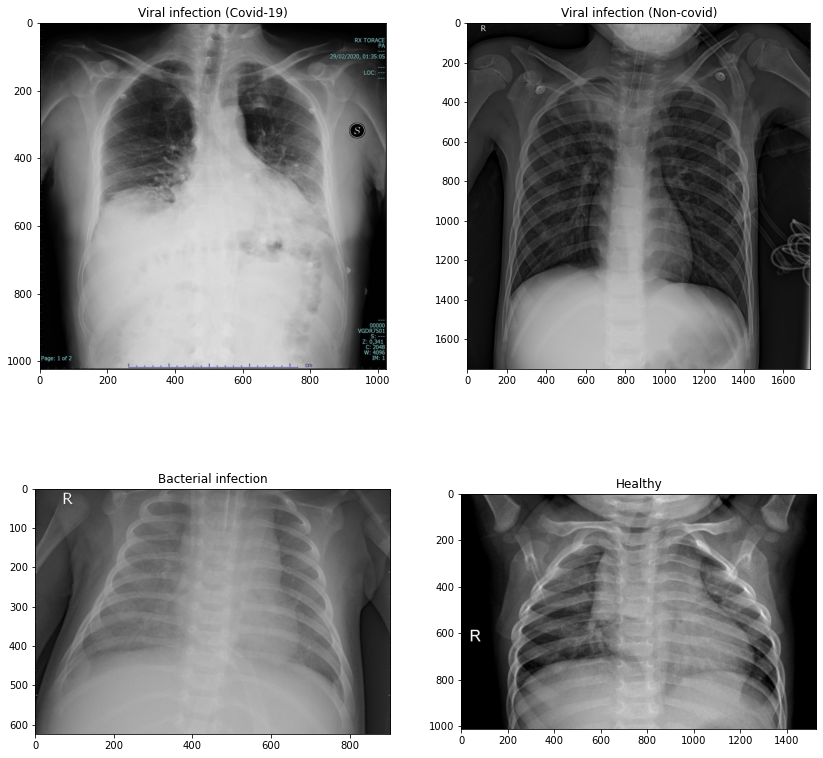

In [17]:
#Getting some sample images

normal = df_train[df_train['Label'] == 'Normal']['X_ray_image_name'].iloc[0]
bacteria = df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'].iloc[0]
virus_covid = df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].iloc[10]
virus_noncovid = df_train[(df_train['Label_2_Virus_category'] != 'COVID-19')
                          &
                          (df_train['Label_1_Virus_category'] == 'Virus')]['X_ray_image_name'].iloc[0]


covid_img = load_img('./Pictures/train/covid-19/{}'.format(virus_covid))
virus_noncovid_img = load_img('./Pictures/train/virus(non-covid)/{}'.format(virus_noncovid))
bacteria_img = load_img('./Pictures/train/bacteria/{}'.format(bacteria))
normal_img = load_img('./Pictures/train/normal/{}'.format(normal))



#Plotting the images

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14,14))



ax[0][0].imshow(covid_img)
ax[0][0].set_title('Viral infection (Covid-19)')

ax[0][1].imshow(virus_noncovid_img)
ax[0][1].set_title('Viral infection (Non-covid)')

ax[1][0].imshow(bacteria_img)
ax[1][0].set_title('Bacterial infection')

ax[1][1].imshow(normal_img)
ax[1][1].set_title('Healthy')


plt.show()

# Doing image augmentation

There are only 58 images of COVID-19 labelled X-rays in our dataset which is tragic, so we will attempt to some image augmentation.

Here we will try to artificially generate images so we can have a larger training dataset. First we decide what kind of image transformations will be appropriate, and then proceed with the generation.

In [18]:
#Import libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img

### Horizontal image shifting

In [19]:
#Convert the data to a numpy array

img_array = img_to_array(covid_img)

img_array.shape

(1024, 1024, 3)

In [20]:
#Expand the dimensions by 1 to fit tensorflow's requirements

img_array_exp = np.expand_dims(img_array, 0)

img_array_exp.shape

(1, 1024, 1024, 3)

In [21]:
imagegen = ImageDataGenerator(width_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

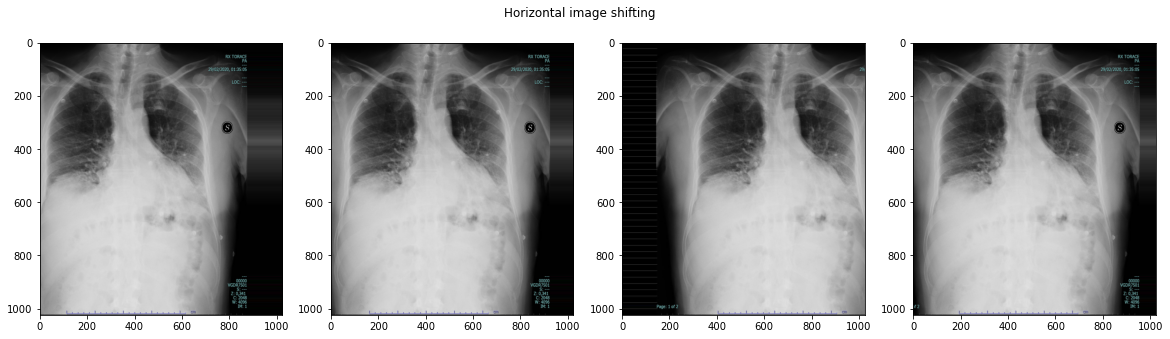

In [22]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal image shifting')
plt.show()

### Vertical image shifting


In [23]:
imagegen = ImageDataGenerator(height_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

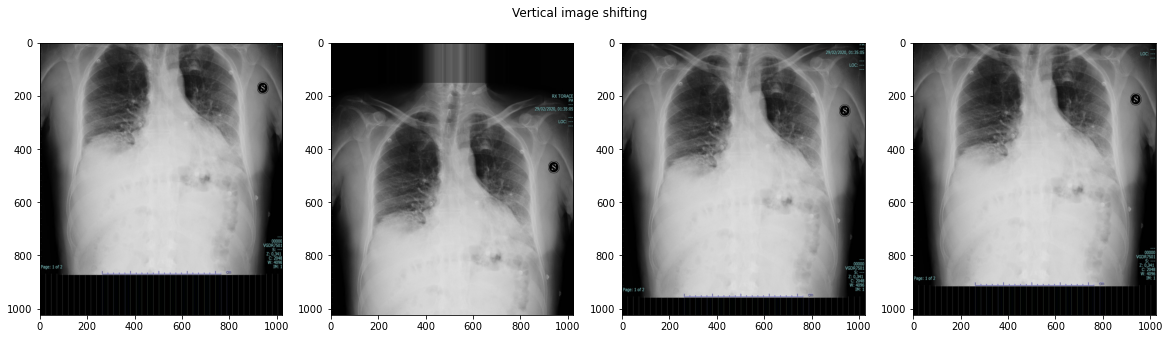

In [24]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Vertical image shifting')
plt.show()

### Horizontal flipping:

In [25]:
imagegen = ImageDataGenerator(horizontal_flip = True)

iterator = imagegen.flow(img_array_exp)

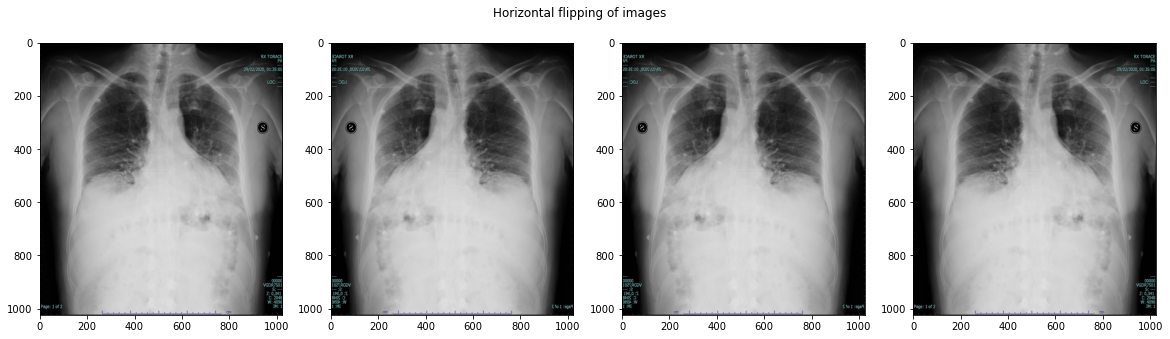

In [26]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal flipping of images')
plt.show()

### Vertical flipping:

Vertical flipping would not be realistic for X-ray images so we exclude that. Therefore we will use the previous 3 image transformations to generate new data. 

# Load images into keras image generators

In [27]:
#Prepare our generator

generator = ImageDataGenerator(width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True)

In [28]:
#Attach generator to the directories

train_generator = generator.flow_from_directory(directory = './Pictures/train',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                                batch_size = 16)

test_generator = generator.flow_from_directory(directory = './Pictures/test',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale')

Found 5276 images belonging to 4 classes.
Found 632 images belonging to 4 classes.


In [29]:
#Old code without image generation, preparing static dataset

from keras.preprocessing import image_dataset_from_directory

training_ds = image_dataset_from_directory(directory = './Pictures/train',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale',
                                           batch_size = 8)
testing_ds = image_dataset_from_directory(directory = './Pictures/test',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')


Found 5276 files belonging to 4 classes.
Found 632 files belonging to 4 classes.


### Preparing class weights for model fitting:

In [30]:
#Put the class counts in to a dictionary:

classes = os.listdir('./Pictures/train')
classes.remove('desktop.ini')

class_count = dict()

for i in classes:
    class_count[i] = len(os.listdir('./Pictures/train/{}'.format(i)))

class_count

{'bacteria': 2536, 'covid-19': 51, 'normal': 1343, 'virus(non-covid)': 1350}

In [31]:
#Compute class weights:

total_sum = sum(class_count.values())

class_weights = {list(class_count.keys())[label]: 1/(count/total_sum) for label, count in enumerate(class_count.values())}

#Check output:

class_weights

{'bacteria': 2.082018927444795,
 'covid-19': 103.52941176470588,
 'normal': 3.9314966492926287,
 'virus(non-covid)': 3.911111111111111}

In [32]:
#Weight for covid-19 cases (label 1) is a little high so we can adjust it downwards

class_weights[1] = 20.0

class_weights

{'bacteria': 2.082018927444795,
 'covid-19': 103.52941176470588,
 'normal': 3.9314966492926287,
 'virus(non-covid)': 3.911111111111111,
 1: 20.0}

### Make model

In [33]:
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, load_model
from keras.metrics import AUC, Precision, Recall
from keras.optimizers import Adam

In [34]:
model = load_model('./Models/Model_six_with_augmentation')

In [35]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 251, 251, 64)      0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 249, 249, 128)     73856     
_________________________________________________________________
flatten_31 (Flatten)         (None, 7936128)           0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 31744516  
Total params: 31,855,940
Trainable params: 31,855,940
Non-trainable params: 0
_________________________________________

## Using Keras Tuner to tune model hyperparameters:

First we define a function that builds a compiled model, which takes in one 'hyperparameter' argument:

In [42]:
def build_model(hp):
    
    #Instantiate model:
    model = keras.Sequential()
    
    #Tune first layer:
    
    filters_choices1 = hp.Choice('filters', [8,16,32])
    
    model.add(Conv2D(filters_choices1, 
                     kernel_size = (30,30), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 #kernel_regularizer=keras.regularizers.l1(0.01), #Regularization to prevent overfitting
                 activation = 'relu', 
                 padding = 'same')) #Zero pad the borders 
    
    
    model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning

    model.add(Conv2D(filters_choices1,
                     kernel_size = (30,30), 
                     #kernel_regularizer=keras.regularizers.l1(0.01),
                     activation = 'relu',
                     padding = 'valid'))

    model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning

    
    filters_choices2 = hp.Choice('filters', [16,32,64])
    model.add(Conv2D(filters_choices2, 
                     kernel_size = (30,30), 
                     #kernel_regularizer=keras.regularizers.l1(0.01),
                     activation = 'relu',
                     padding = 'valid'))
    model.add(Flatten())

    model.add(Dense(84, activation = 'relu'))
    
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(optimizer = Adam(hp.Choice('learning_rate', [0.01,0.001,0.0001])
                                  ),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = ['accuracy', AUC(), Precision(), Recall()])
    
    return model

We instantiate the tuner, in this case we use the Hyperband algorithm. There are other built-in algorithms available like Bayesian Optimization and Random Search.

In [55]:
tuner = kt.Hyperband(build_model,
                     objective = 'accuracy', 
                     max_epochs = 50,
                     hyperband_iterations = 3,
                     project_name = 'Keras Tuner'
                    )

In [56]:
#Create an early stopping callback to stop model training if loss stagnates

stopper_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [57]:
tuner.search(train_generator, 
             callbacks = [stopper_callback], 
             epochs = 50, 
             class_weight = class_weights)

Trial 8 Complete [00h 01m 43s]
accuracy: 0.5873767733573914

Best accuracy So Far: 0.6637604236602783
Total elapsed time: 00h 13m 15s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
filters           |8                 |16                
learning_rate     |0.0001            |0.0001            
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |3                 |3                 
tuner/round       |0                 |0                 

Epoch 1/2
230/330 [===================>..........] - ETA: 14s - loss: 1.4991 - accuracy: 0.4472 - auc: 0.6836 - precision: 0.4176 - recall: 0.0724

KeyboardInterrupt: 

In [317]:
model = Sequential()

#Stage 1
model.add(Conv2D(filters = 6, kernel_size = (30,30), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 #kernel_regularizer=keras.regularizers.l1(0.01), #Regularization to prevent overfitting
                 activation = 'relu', 
                 padding = 'same')) #Zero pad the borders 

model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning

model.add(Conv2D(filters = 18, kernel_size = (30,30), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))

model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2) )) #Pooling to accelerate learning


model.add(Conv2D(filters = 120, kernel_size = (30,30), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Flatten())

model.add(Dense(84, activation = 'relu'))

#model.add(Dropout(0.4)) #Dropout to prevent overfitting

'''
#Stage 2
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
         
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (3,3))) 
#model.add(Dropout(0.4)) 


#Stage 3
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (2,2))) 
#model.add(Dropout(0.4))


#Stage 4
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (2,2))) 



#Layer 4
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
#model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4))


#Layer 5
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
#model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4)) 
'''

#Flatten outputs before dense layers
#model.add(Dropout(0.2))
#model.add(Flatten())

#A couple of dense layers
#model.add(Dense(10, activation = 'relu'))
#model.add(Dense(100, activation = 'relu'))

#Dense layer for decision output
model.add(Dense(4, activation = 'softmax'))


In [318]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy', AUC(), Precision(), Recall()])

In [323]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 251, 251, 64)      0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 249, 249, 128)     73856     
_________________________________________________________________
flatten_31 (Flatten)         (None, 7936128)           0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 31744516  
Total params: 31,855,940
Trainable params: 31,855,940
Non-trainable params: 0
_________________________________________

In [320]:
#Create a scheduler to adjust learning rate across epochs

#Define a function to apply a time-based decay to learning rate
#after 100 epochs

def decay(epoch, lr, decayspeed = 0.1):
    if epoch < 20:
        return lr
    else:
        return lr/(1+(decayspeed*epoch))

#Create a scheduler

from keras.callbacks import LearningRateScheduler

scheduler = LearningRateScheduler(decay)

In [321]:
#Fit the model using augmented images and a scheduler to dceay learning rate

history = model.fit(x = train_generator, 
                    epochs = 100, 
                    steps_per_epoch= None,
                    callbacks = scheduler,
                    class_weight = class_weights
                   )

Epoch 1/100
330/330 [==============================] - 47s 144ms/step - loss: 215.5816 - accuracy: 0.4621 - auc_40: 0.7355 - precision_40: 0.5232 - recall_40: 0.0728
Epoch 2/100
330/330 [==============================] - 48s 145ms/step - loss: 3.5617 - accuracy: 0.5826 - auc_40: 0.8156 - precision_40: 0.6637 - recall_40: 0.2098
Epoch 3/100
330/330 [==============================] - 47s 142ms/step - loss: 3.3474 - accuracy: 0.6317 - auc_40: 0.8434 - precision_40: 0.6667 - recall_40: 0.3180
Epoch 4/100
330/330 [==============================] - 47s 142ms/step - loss: 3.2155 - accuracy: 0.6401 - auc_40: 0.8448 - precision_40: 0.6752 - recall_40: 0.4232
Epoch 5/100
330/330 [==============================] - 47s 143ms/step - loss: 3.1927 - accuracy: 0.6480 - auc_40: 0.8515 - precision_40: 0.6781 - recall_40: 0.4041
Epoch 6/100
330/330 [==============================] - 49s 149ms/step - loss: 3.1253 - accuracy: 0.6495 - auc_40: 0.8561 - precision_40: 0.6843 - recall_40: 0.4240
Epoch 7/100
33

KeyboardInterrupt: 

In [38]:
#Save model

model.save('./Models/Model_six_with_augmentation/', overwrite = False)

[WARNING] ./Models/Model_six_with_augmentation/ already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
INFO:tensorflow:Assets written to: ./Models/Model_six_with_augmentation/assets


In [244]:
#Unlock this cell if it's the first time training the model:

mainhistory = copy.deepcopy(history.history)


In [14]:
#Unlock this cell if loading previous history file:
'''
import pickle

#Load main epoch history


with open('./Models/Model_six_with_augmentation/history.p', 'rb') as readingfile:
    mainhistory = pickle.load(readingfile)
 
'''

In [15]:
mainhistory.keys()

dict_keys(['loss', 'accuracy', 'auc_26', 'precision_26', 'recall_26', 'lr'])

In [16]:
#Unlock this cell if updating previous history file:

'''
#Unlock this cell when training the model


#Update main history dictionary with new batch

for key in history.history.keys():
    if key == 'auc_32':
        mainhistory['auc_26'].extend(history.history[key])
    elif key == 'precision_32':
        mainhistory['precision_26'].extend(history.history[key])
    elif key == 'recall_32':
        mainhistory['recall_26'].extend(history.history[key])
    else:
        mainhistory[key].extend(history.history[key])
    
print('{} new entries added to main history dictionary'.format(len(history.history['loss'])))

'''

"\n#Unlock this cell when training the model\n\n\n#Update main history dictionary with new batch\n\nfor key in history.history.keys():\n    if key == 'auc_32':\n        mainhistory['auc_26'].extend(history.history[key])\n    elif key == 'precision_32':\n        mainhistory['precision_26'].extend(history.history[key])\n    elif key == 'recall_32':\n        mainhistory['recall_26'].extend(history.history[key])\n    else:\n        mainhistory[key].extend(history.history[key])\n    \nprint('{} new entries added to main history dictionary'.format(len(history.history['loss'])))\n\n"

In [17]:
#Save main dictionary:

'''
import pickle

with open('./Models/Model_six_with_augmentation/history.p', 'wb') as outfile:
    pickle.dump(mainhistory, outfile)
'''

"\nimport pickle\n\nwith open('./Models/Model_six_with_augmentation/history.p', 'wb') as outfile:\n    pickle.dump(mainhistory, outfile)\n"

## Evaluate model

In [40]:
#Summary of model:

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 251, 251, 64)      0         
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 249, 249, 128)     73856     
_________________________________________________________________
flatten_31 (Flatten)         (None, 7936128)           0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 31744516  
Total params: 31,855,940
Trainable params: 31,855,940
Non-trainable params: 0
_________________________________________

In [67]:
#Evaluate against test data:

evaluate = model.evaluate(testing_ds)

20/20 [==============================] - 34s 2s/step - loss: 1.0358 - accuracy: 0.6693 - auc_32: 0.8263 - precision_32: 0.7889 - recall_32: 0.3370


In [47]:
#Metrics contained in our training history file:

mainhistory.keys()

dict_keys(['loss', 'accuracy', 'auc_26', 'precision_26', 'recall_26', 'lr'])

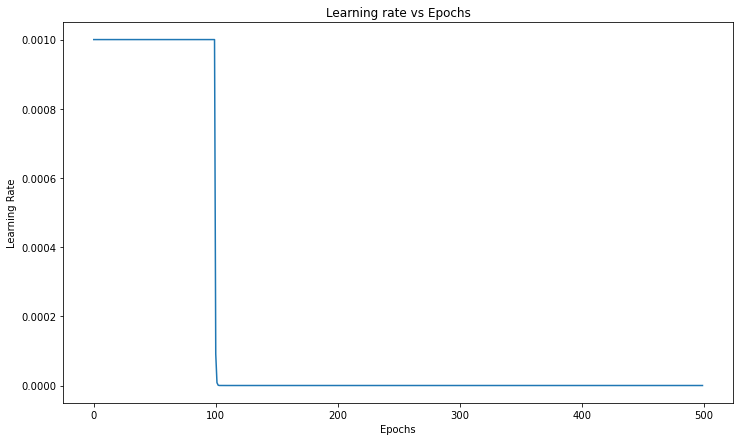

In [60]:
plt.figure(figsize = (12,7))

plt.plot(mainhistory['lr'])

plt.title('Learning rate vs Epochs')
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

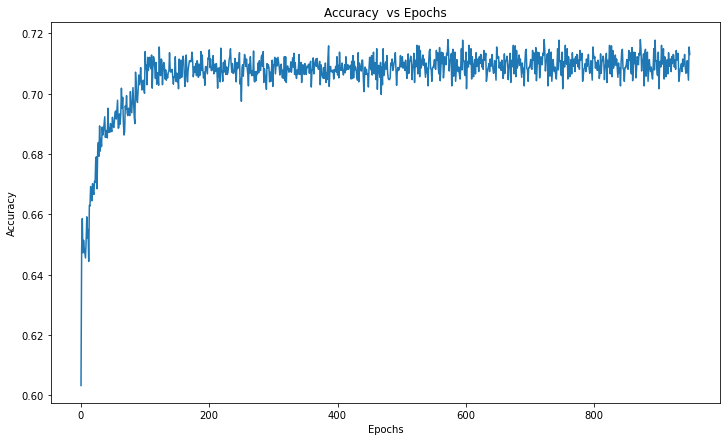

In [61]:
plt.figure(figsize = (12,7))
plt.plot(mainhistory['accuracy'])

plt.title('Accuracy  vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

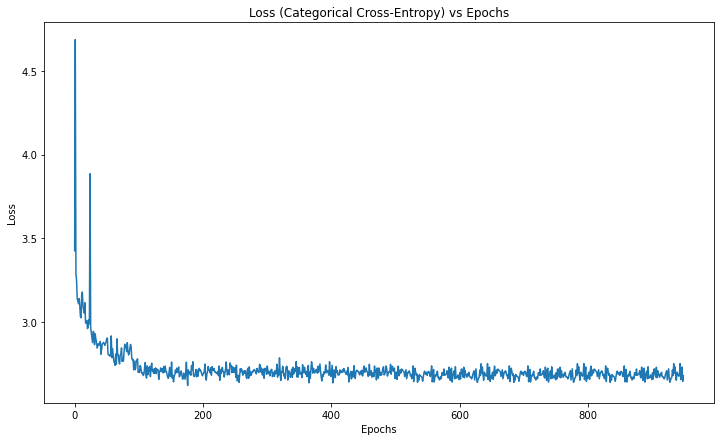

In [62]:
plt.figure(figsize = (12,7))

plt.plot(mainhistory['loss'][1:])

plt.title('Loss (Categorical Cross-Entropy) vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

### Confusion matrix and classification report (Train):

In [59]:
#Similarly prepare a train generator with shuffle = False

train_generator = generator.flow_from_directory(directory = './Pictures/train',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                               shuffle = False)
train_predict = model.predict(train_generator)

train_predicted_classes = np.argmax(train_predict, axis = 1)
train_true_classes = train_generator.classes

Found 5276 images belonging to 4 classes.


NameError: name 'model' is not defined

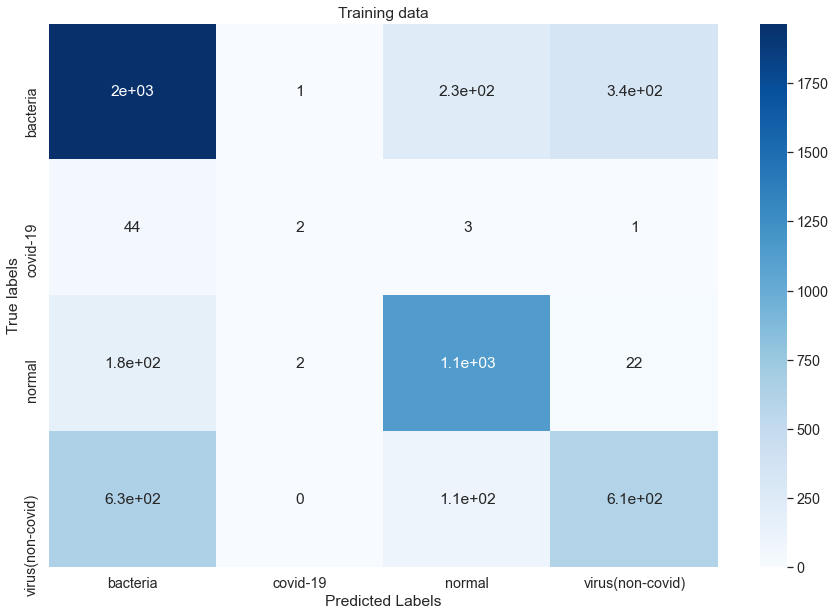

In [87]:
cm = confusion_matrix(train_true_classes, train_predicted_classes)

df_cm = pd.DataFrame(cm,
                     index = class_count.keys(),
                     columns = class_count.keys())

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

sns.heatmap(df_cm, annot = True, cmap = 'Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True labels')

plt.title('Training data')
plt.show()

In [86]:
from sklearn.metrics import classification_report

print(classification_report(train_true_classes, train_predicted_classes, target_names = class_count.keys()))

                  precision    recall  f1-score   support

        bacteria       0.70      0.78      0.73      2535
        covid-19       0.40      0.04      0.07        50
          normal       0.77      0.85      0.81      1342
virus(non-covid)       0.63      0.45      0.53      1349

        accuracy                           0.71      5276
       macro avg       0.62      0.53      0.54      5276
    weighted avg       0.70      0.71      0.69      5276



### Confusion matrix and classification report (Test):

In [71]:
#Prepare a test generator with shuffle = False so we can identify the true/predicted classes

test_generator = generator.flow_from_directory(directory = './Pictures/test',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                               shuffle = False)

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes

Found 632 images belonging to 4 classes.


In [58]:
cm = confusion_matrix(true_classes, predicted_classes)

df_cm = pd.DataFrame(cm,
                     index = class_count.keys(),
                     columns = class_count.keys())

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

sns.heatmap(df_cm, annot = True, cmap = 'Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True labels')

plt.title('Test data')



plt.show()

NameError: name 'true_classes' is not defined

In [73]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names = class_count.keys()))

                  precision    recall  f1-score   support

        bacteria       0.58      0.88      0.70       242
        covid-19       0.00      0.00      0.00         8
          normal       0.75      0.42      0.54       234
virus(non-covid)       0.81      0.72      0.76       148

        accuracy                           0.66       632
       macro avg       0.53      0.50      0.50       632
    weighted avg       0.69      0.66      0.64       632



The model 